## Introduction
Before we jump into the deep end of the MCP world, lets go through the key concepts. `Model Context Protocol (MCP)` an open standard protocol developed at Anthropic, standardises how your LLM connects to the differnt tools and data sources. MCP borrows its ideas from REST APIs (standardised how web apps interact with backend) and LSPs (standardised how IDEs interact with language specific tools).

With MCP, developer responsibilities can be isolated. Developers can build LLM applications (clients) and re-use connectors (servers) as opposed to building the custom connectors

MCP is built based on client - host - server architecture.  has 3 key components

##### Host 
It can be any IDEs, tools that want to access the data through MCP. Each Host can run multiple clients. Think of host like a container
##### Client
Each client maintains 1:1 relationship with the server
##### Server
Servers provide context to the LLMs by exposing `tools`,`resources` and `prompts`  
Tools are used for execution (like a `POST` request) Resources are used for `get` information

MCP server has two variations, you can either use FastMCP or write the server implementation from scratch using MCPServer

FastMCP - higher level construct that abstracts most of the boiler plate code of MCPServer, provides simplified APIs for tools, resources and prompts. It also handles the HTTP transports, manages authentication


Lets start the notebook by uninstalling and reinstalling some of the required packages, including LangChain for pre-built tool components, LangGraph for agent workflows, and other necessary libraries.

In [16]:
%pip uninstall boto3 botocore awscli --yes

Found existing installation: boto3 1.40.3
Uninstalling boto3-1.40.3:
  Successfully uninstalled boto3-1.40.3
Found existing installation: botocore 1.40.3
Uninstalling botocore-1.40.3:
  Successfully uninstalled botocore-1.40.3
Found existing installation: awscli 1.42.3
Uninstalling awscli-1.42.3:
  Successfully uninstalled awscli-1.42.3
Note: you may need to restart the kernel to use updated packages.


Before we begin , we will use Jupyter magic command to  handle the async context. So we don't need to explicitly use asyncio.run() to execute async functions

In [17]:
%autoawait on

In [18]:
%pip install -r requirements.txt -q --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.3.1 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
dash 2.18.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-table==5.0.0, which is not installed.
jupyter-ai 2.31.5 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
aiobotocore 2.21.1 requires botocore<1.37.2,>=1.37.0, but you have botocore 1.40.3 which is incompatible.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires ipython<9,>=8.33.0, but you have ipython 8.29.0 which is incompatible.
autogluon-multimodal 1.3.1 requires jsonschema<4.24,>=4.18, but you have jsonschema 4.25.0 which is incompatible.
autogluon-multimodal 1.3.1 requires nltk<3.9,>=3.4.5, but you have nltk 3.9.1 which is i

In [19]:
# restart kernel for packages to take effect
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Open the terminal and start the MCP server by running this command

```bash
python Mortgage_Assistant/3_mcp-server-client/strands_mcp/creditcheck_server_http.py



You might see an output like this
```bash
% python 4_mcp-server-client/strands_mcp/creditcheck_server_http.py
INFO:     Started server process [63536]
INFO:     Waiting for application startup.
StreamableHTTP session manager started
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8080 (Press CTRL+C to quit)
INFO:     127.0.0.1:53817 - "POST /mcp HTTP/1.1" 307 Temporary Redirect

Copy the relevant server url and update the `mcp_server.json` file. Leave the `/mcp` in the config at the end of the URL




Import the following modules

In [1]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
import os
import boto3
from IPython.display import display,Image, HTML
import random
from textwrap import dedent
from langgraph.checkpoint.memory import InMemorySaver
import json
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph_swarm import create_handoff_tool, create_swarm
from langchain_core.messages import ToolMessage, AIMessage
import certifi
from datetime import datetime, timedelta



Since we are building the multi-agent workflow on LangGraph, we can use `MultiServerMCPClient`. This library is  used for connecting to multiple MCP servers and  get tools, prompts and resources from the server, and automatically does the conversion from mcp specific details into langchain compatible format. 


In [2]:
# we will bring in mcp server configuration
with open('config/mcp_server.json', 'r') as f:
    mcp_server = json.load(f) 

We will initiate the client and use the `get_tools()`

In [3]:
client =  MultiServerMCPClient(mcp_server)
tools = await client.get_tools()


Unblock the code in the below cell and run to get more info about the tools


In [4]:
# for tool in tools:
#     print(f"Name: {tool.name}")
#     print(f"Description: {tool.description}")
#     print(f"Schema: {tool.args_schema}")

If you're running this notebook locally, set the AWS_PROFILE

In [5]:
# os.environ['AWS_PROFILE']='stcgenai'

If you run into SSL certificate issues, run the following code block in Python cell

In [6]:
# cert_path = certifi.where()
# print(f"Using certificate bundle at: {cert_path}")

# # Set environment variable
# os.environ['AWS_CA_BUNDLE'] = cert_path

Next, we will continue on initiating the AgentState, LLM and memory respectively. 

Depending on the model availability and the region  you are running this lab, change the agent_foundation_model[] and region_name before instantiating the boto client

In [51]:
class AgentState(MessagesState):
    pass

agent_foundation_model = [
    'us.anthropic.claude-3-5-haiku-20241022-v1:0'
    ]

bedrock_client = boto3.client('bedrock-runtime')

model = init_chat_model(
    agent_foundation_model[0],
    model_provider="bedrock_converse",
    temperature=0.7,
    client=bedrock_client
)

memory = InMemorySaver()

We will define the same tools we used in the LangGraph multi agent notebook

In [52]:
def get_mortgage_details(customer_id: str) -> str:
    """
Retrieves the mortgage status for a given customer ID. Returns an object containing 
details like the account number, 
outstanding principal, interest rate, maturity date, number of payments remaining, due date of next payment, 
and amount of next payment."""
    return {
        "account_number": customer_id,
        "outstanding_principal": 150599.25,
        "interest_rate": 8.5,
        "maturity_date": "2030-06-30",
        "original_issue_date": "2021-05-30",
        "payments_remaining": 72,
        "last_payment_date": str(datetime.today() - timedelta(days=14)).split(' ')[0],
        "next_payment_due": str(datetime.today() + timedelta(days=14)).split(' ')[0],
        "next_payment_amount": 1579.63
    }


def get_application_details(customer_id: str) -> str:
    """Retrieves the details about an application for a new mortgage. The function takes a customer ID, but it is purely optional. 
    The function implementation can retrieve it from session state instead. 
    Details include the application ID, application date, application status, application type, application amount, application tentative rate, and application term in years."""
    return {
        "customer_id": customer_id,
        "application_id": "998776",
        "application_date": datetime.today() - timedelta(days=35), # simulate app started 35 days ago
        "application_status": "IN_PROGRESS",
        "application_type": "NEW_MORTGAGE",
        "application_amount": 750000,
        "application_tentative_rate": 5.5,
        "application_term_years": 30,
        "application_rate_type": "fixed"
    }


def get_mortgage_rate_history(day_count: int=30, type: str="15-year-fixed"):
    """Retrieves the history of mortgage interest rates going back a given number of days, defaults to 30. History is returned as a list of objects, where each object contains the date and the interest rate to 2 decimal places."""
    BASE_RATE=6.00

    RATE_MIN_15=38
    RATE_MAX_15=48

    RATE_MIN_30=RATE_MIN_15 + 80
    RATE_MAX_30=RATE_MAX_15 + 80
    
    # print(f"getting rate history for: {day_count} days, for type: {type}...")
    # generate the last 7 working day dates starting with yesterday
    today = datetime.today()
    history_count = 0
    rate_history = []

    if type == "30-year-fixed":
        RATE_MIN = RATE_MIN_30
        RATE_MAX = RATE_MAX_30
    else:
        RATE_MIN = RATE_MIN_15
        RATE_MAX = RATE_MAX_15

    for i in range(int(day_count*1.4)):
        if history_count >= day_count:
            break
        else:
            day = today - timedelta(days=i+1)
            which_day_of_week = day.weekday()
            if which_day_of_week < 5:
                history_count += 1
                _date = str(day.strftime("%Y-%m-%d"))
                _rate = f"{BASE_RATE + ((random.randrange(RATE_MIN, RATE_MAX))/100):.2f}"
                rate_history.append({"date": _date, "rate": _rate})

    return rate_history


def get_mortgage_app_doc_status(customer_id: str):
    """
    Retrieves the list of required documents for a mortgage application in process, along with their respectiv statuses (COMPLETED or MISSING).
    The function takes a customer ID, but it is purely optional. The funciton implementation can retrieve it from session state instead. 
    This function returns a list of objects, where each object represents a required document type. 
    The required document types for a mortgage application are: proof of income, employment information, proof of assets, and credit information. Each object in the returned list contains the type of the required document and its corresponding status."""
    return [
        {
            "type": "proof_of_income",
            "status": "COMPLETED"
        },
        {
            "type": "employment_information",
            "status": "MISSING"
        },
        {
            "type": "proof_of_assets",
            "status": "COMPLETED"
        },
        {
            "type": "credit_information",
            "status": "COMPLETED"
        }
    ]

In [53]:
# Retrieve knowledge base ID from previous notebook
%store -r kb_id
os.environ["KNOWLEDGE_BASE_ID"] = kb_id
print("Knowledge Base ID:", kb_id)

Knowledge Base ID: GO3CLYUJPK


 Lets add a RAG and add to the graph. We shall use Bedrock's Knowledge Base , the managed RAG offering. Replace the `knowledge_base_id` with the KB you created in the previous labs

For this scenario we will use  `AmazonKnowledgeBasesRetriever` class from  the langchain_aws module. 

<div class="alert alert-block alert-info">
Replace the KB id from the Bedrock modules
</div>

In [54]:
from langchain_aws.retrievers import AmazonKnowledgeBasesRetriever

retriever = AmazonKnowledgeBasesRetriever(
                knowledge_base_id=kb_id,
                retrieval_config={
                    "vectorSearchConfiguration": {
                        "numberOfResults": 4
                    }
                
                },
            )


Now, we test to see if the KB is working as expected

In [55]:
retriever.invoke("What is the benefit of refinancing, if any?")


[Document(metadata={'location': {'s3Location': {'uri': 's3://mac-workshop-us-west-2-706316750687/Mortgage Refinancing When Does It Make Sense .html'}, 'type': 'S3'}, 'score': 0.5549688, 'type': 'TEXT', 'source_metadata': {'x-amz-bedrock-kb-source-uri': 's3://mac-workshop-us-west-2-706316750687/Mortgage Refinancing When Does It Make Sense .html', 'x-amz-bedrock-kb-chunk-id': '1%3A0%3AmcTJcpgB0iBd7qYqNAek', 'x-amz-bedrock-kb-data-source-id': 'UEGSCQYJW0'}}, page_content="More to the point, consider whether the monthly savings is enough to make a positive change in your life, or whether the overall savings over the life of the loan will benefit you substantially. ## Refinancing to Secure a Lower Interest Rate One of the best reasons to refinance is to lower the interest rate](https://www.investopedia.com/articles/investing/080713/how-banks-set-interest-rates-your-loans.asp) on your existing loan. Historically, the rule of thumb is that refinancing is a good idea if you can reduce your int

Once we create the retriever and tested it, lets wrap it using the langchain `Tool` and use the `retrieve.invoke()` function 

In [56]:
from langchain.tools import Tool

retriever_tool = Tool(
    name="amazon_knowledge_base",
    description="Use this knowledge base to answer general questions about mortgages, like how to refinnance, or the difference between 15-year and 30-year mortgages.",
    func=lambda query: "\n\n".join([doc.page_content for doc in retriever.invoke(query)])
)

Load the system prompt files before invoking them

In [57]:
def load_system_prompt(filename):
    """Load system prompt from markdown file"""
    with open(f'config/{filename}', 'r') as f:
        return f.read()

Create the hand off tools and react agents

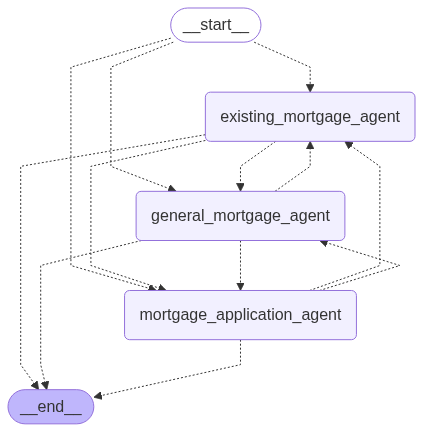

In [58]:
# Define handoff tool
transfer_to_existing_assistant = create_handoff_tool(
    agent_name="existing_mortgage_agent",
    description="Transfer user to the existing mortgage agent to provide information about current mortgage  details including outstanding principal, interest rates, maturity dates, payment schedules, and upcoming payment information. Use this when the user is asking about their existing mortgage account, payment details, or loan status. "
)

# Define handoff tool
transfer_to_application_assistant = create_handoff_tool(
    agent_name="mortgage_application_agent",
    description="Transfer user to the mortgage application agent to provide assistance with new mortgage applications, document status tracking, application details, and historical mortgage rate information. Use this when the user is asking about applying for a new mortgage, checking application status, or needs information about current mortgage rates."
)

# Define handoff tool
transfer_to_general_mortgage_agent = create_handoff_tool(
    agent_name="general_mortgage_agent",
    description="Transfer user to the general mortgage agent to use knowledge base to answer general questions about mortgages, like how to refinnance, or the difference between 15-year and 30-year mortgages."

)

# Define the Agent
general_mortgage_agent = create_react_agent(
    model=model,
    tools=[retriever_tool,transfer_to_existing_assistant,transfer_to_application_assistant],
    prompt=dedent(load_system_prompt("general_assistant_system.md")),
    name="general_mortgage_agent")

# Define the Agent
existing_mortgage_agent = create_react_agent(
    model=model,
    tools=[get_mortgage_details,transfer_to_application_assistant, transfer_to_general_mortgage_agent],
    prompt=dedent(load_system_prompt("existing_mortgage_system.md")),
    name="existing_mortgage_agent"
)

# Define the Agent
mortgage_application_agent = create_react_agent(
    model=model,
    tools=[get_application_details,get_mortgage_rate_history,get_mortgage_app_doc_status,transfer_to_existing_assistant,transfer_to_general_mortgage_agent],
    prompt=dedent("mortgage_application_system.md"),
    name="mortgage_application_agent")

graph = create_swarm([existing_mortgage_agent,mortgage_application_agent,general_mortgage_agent],default_active_agent="general_mortgage_agent")

app = graph.compile(checkpointer=memory)
config = {"configurable": {"thread_id": random.randint(1,10000)}}

display(Image(app.get_graph().draw_mermaid_png()))

Firstly, we test the multi agent functionality

In [59]:
response = app.invoke(
    {"messages": "I need a complete mortgage consultation. First, I want to check my existing mortgage details for customer ID xyz to see my current situation. Then I need to understand the market by showing me the 30-year fixed mortgage rate history for the past 30 days to compare with my current rate. Finally, I have a general question about mortgage refinancing - what are the key factors I should consider when deciding whether to refinance my mortgage, and what's the difference between a 15-year and 30-year mortgage in terms of total cost"},
    config
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

I need a complete mortgage consultation. First, I want to check my existing mortgage details for customer ID xyz to see my current situation. Then I need to understand the market by showing me the 30-year fixed mortgage rate history for the past 30 days to compare with my current rate. Finally, I have a general question about mortgage refinancing - what are the key factors I should consider when deciding whether to refinance my mortgage, and what's the difference between a 15-year and 30-year mortgage in terms of total cost
================================== Ai Message ==================================
Name: general_mortgage_agent

[{'type': 'text', 'text': "I'll help you through this comprehensive mortgage consultation step by step.\n\n1. First, let's check your existing mortgage details:"}, {'type': 'tool_use', 'name': 'transfer_to_existing_mortgage_agent', 'input': {}, 'id': 'tooluse_FxEm_J1sSYKNKtbDv

Great, now that the multi agent system works. Now we add the MCP agent to it. First we create a new hand off tool

In [32]:
transfer_to_credit_check_agent = create_handoff_tool(
    agent_name="credit_check_agent",
    description="Transfer user to the credit check agent to check credit score for the customer id"
)

Since the MCP invocation `list_tools()` returns a list of tools, ideally we would iterate through the list, but in this scenario, we only have one tool so we directly attach the first object

In [33]:
mcp_tool = tools[0]

Let's create a new agent and test out the credit score

In [34]:
credit_check_agent = create_react_agent(
    model=model,
    tools=[mcp_tool,transfer_to_existing_assistant,transfer_to_general_mortgage_agent,transfer_to_application_assistant],
    prompt=dedent(mcp_tool.description),
    name="credit_check_agent")

In [35]:
response = await credit_check_agent.ainvoke({"messages": "what is my credit score, here is my id 1111"})

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is my credit score, here is my id 1111
================================== Ai Message ==================================
Name: credit_check_agent

[{'type': 'text', 'text': "I'll help you check your credit score using the provided customer ID."}, {'type': 'tool_use', 'name': 'credit_check', 'input': {'customer_id': 1111}, 'id': 'tooluse_GBX56Ho_TeSoU9r4_LeEqw'}]
Tool Calls:
  credit_check (tooluse_GBX56Ho_TeSoU9r4_LeEqw)
 Call ID: tooluse_GBX56Ho_TeSoU9r4_LeEqw
  Args:
    customer_id: 1111
================================= Tool Message =================================
Name: credit_check

70
================================== Ai Message ==================================
Name: credit_check_agent

Your credit score is 70. This is considered a relatively low credit score. Credit scores typically range from 300 to 850, with higher scores indicating better creditworthiness. A score of 70 suggests you mig

Lets update the existing agents by adding the newly created hand off tool for `credit_check`

In [36]:
# Recreate the Agent with new hand off tool
general_mortgage_agent = create_react_agent(
    model=model,
    tools=[retriever_tool,transfer_to_existing_assistant,transfer_to_application_assistant,transfer_to_credit_check_agent],
    prompt=dedent(load_system_prompt("general_assistant_system.md")),
    name="general_mortgage_agent")

# Recreate the Agent with new hand off tool
existing_mortgage_agent = create_react_agent(
    model=model,
    tools=[get_mortgage_details,transfer_to_application_assistant, transfer_to_general_mortgage_agent,transfer_to_credit_check_agent],
    prompt=dedent(load_system_prompt("existing_mortgage_system.md")),
    name="existing_mortgage_agent"
)

# Recreate the Agent with new hand off tool
mortgage_application_agent = create_react_agent(
    model=model,
    tools=[get_application_details,get_mortgage_rate_history,get_mortgage_app_doc_status,transfer_to_existing_assistant,transfer_to_general_mortgage_agent,transfer_to_credit_check_agent],
    prompt=dedent("mortgage_application_system.md"),
    name="mortgage_application_agent")


Finally, we recreate the swarm application by add the `credit_check_agent` and test it

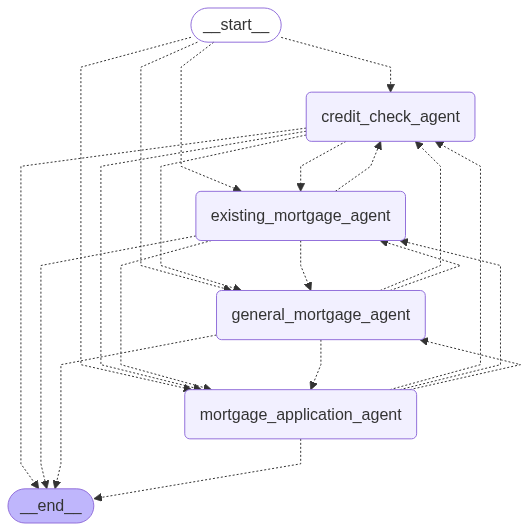

In [37]:
graph = create_swarm([existing_mortgage_agent,mortgage_application_agent,general_mortgage_agent,credit_check_agent],default_active_agent="general_mortgage_agent")

app = graph.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

We are ready to test, yay!

In [38]:
thread_id = {"configurable": {"thread_id": random.randint(1,10000)}}
response = await app.ainvoke({"messages": "Can you show me my current mortgage details and recent rate trends. Here is my id : 12345"},config=thread_id)
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you show me my current mortgage details and recent rate trends. Here is my id : 12345
================================== Ai Message ==================================
Name: general_mortgage_agent

[{'type': 'text', 'text': "I'll help you retrieve your mortgage details and provide some insights. I'll first transfer you to the existing mortgage agent to get your specific account information."}, {'type': 'tool_use', 'name': 'transfer_to_existing_mortgage_agent', 'input': {}, 'id': 'tooluse_PS4yuzppTHmbb7zrZ3Jfsg'}]
Tool Calls:
  transfer_to_existing_mortgage_agent (tooluse_PS4yuzppTHmbb7zrZ3Jfsg)
 Call ID: tooluse_PS4yuzppTHmbb7zrZ3Jfsg
  Args:
================================= Tool Message =================================
Name: transfer_to_existing_mortgage_agent

Successfully transferred to existing_mortgage_agent
================================== Ai Message ==================================
Name: e

Lets try a more complicated prompt and see if the hand off between agents is working

In [39]:
prompt = """I need a complete mortgage portfolio analysis. Here's what I need:

1. First, pull up my existing mortgage details for customer ID '1111' to see my current situation
2. Check my credit score to understand my refinancing eligibility 
3. I also have a new mortgage application in progress for a second property - can you check the application status and show me what documents are still needed?
4. Show me the 30-year fixed mortgage rate history for the past 45 days to compare with my current 8.5% rate
5. Finally, I have some general questions: What are the key benefits of refinancing from a 30-year to a 15-year mortgage, and what factors should I consider when deciding if refinancing makes financial sense?

Please provide a comprehensive analysis covering all these aspects."""

In [40]:
thread_id = {"configurable": {"thread_id": random.randint(1,10000)}}
response = await app.ainvoke({
    "messages": prompt}, config=thread_id)

In [41]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

I need a complete mortgage portfolio analysis. Here's what I need:

1. First, pull up my existing mortgage details for customer ID '1111' to see my current situation
2. Check my credit score to understand my refinancing eligibility 
3. I also have a new mortgage application in progress for a second property - can you check the application status and show me what documents are still needed?
4. Show me the 30-year fixed mortgage rate history for the past 45 days to compare with my current 8.5% rate
5. Finally, I have some general questions: What are the key benefits of refinancing from a 30-year to a 15-year mortgage, and what factors should I consider when deciding if refinancing makes financial sense?

Please provide a comprehensive analysis covering all these aspects.
================================== Ai Message ==================================
Name: general_mortgage_agent

[{'type': 'text', 'text': "

Optionally, you could track the ai_messages and tool_messages separately

```
ai_messages = [msg for msg in response["messages"] if isinstance(msg, AIMessage)]
tool_messages = [msg for msg in response["messages"] if isinstance(msg, ToolMessage)]

for message in ai_messages:
    message.pretty_print()
```


## Summary

In this lab, we covered
- Introduction to Model Context Protocol as an open standard for connecting LLMs to tools and data sources
- How to use MultiServerMCPClient to connect to MCP servers and retrieve tools
- Showcased Config-driven approach to create specialized agents (existing mortgage, mortgage application, and general assistant)
- Using LangGraph Swarm to coordinate between agents with handoff capabilities
- Converting MCP tools to LangChain-compatible format for use in the agentic workflow